In [1]:
import cv2
import numpy as np


import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import optuna
import math

def process_image(path, is_gray=False):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    
    if not is_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    img = img / 255.0
    img = np.reshape(img, (1, 420, 540))  
    
    # 转换为 PyTorch tensor
    img_tensor = torch.from_numpy(img).float()
    
    return img_tensor

In [2]:
import os

# ****************************************************************************************
# download the dataset: https://www.kaggle.com/competitions/denoising-dirty-documents/data
# ****************************************************************************************

train_img = sorted(os.listdir('./train'))
train_cleaned_img = sorted(os.listdir('./train_cleaned'))
test_img = sorted(os.listdir('./test'))

In [3]:
# preprocess images
train = []
train_cleaned = []
test = []

# since train and train_cleaned have the same doc names we can embed them in one loop
for f in train_img:
    train_path = os.path.join('./train', f)
    train_cleaned_path = os.path.join('./train_cleaned', f)
    
    # Check if the images are already in grayscale
    if cv2.imread(train_path).shape[-1] == 1:
        train.append(process_image(train_path, is_gray=True))
        train_cleaned.append(process_image(train_cleaned_path, is_gray=True))
    else:
        train.append(process_image(train_path))
        train_cleaned.append(process_image(train_cleaned_path))

for f in test_img:
    test_path = os.path.join('./test', f)
    # Check if the images are already in grayscale
    if cv2.imread(test_path).shape[-1] == 1:
        test.append(process_image(test_path, is_gray=True))
    else:
        test.append(process_image(test_path))

In [5]:
class Pgelu(nn.Module):
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'$\sigma_{seqFlag}$',0,10) #可学习参数 sigma

    def forward(self, input):
    #    sigma = trial.suggest_float('sigma1',0,10)
        temp2=input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))
        return temp2

In [6]:
class Exlu(nn.Module): 
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'$\sigma_{seqFlag}$',0,10) #可学习参数 sigma

    def forward(self, input):
        temp1=torch.max(torch.zeros_like(input), input)
        temp2=torch.min(torch.zeros_like(input), input*torch.exp(input / self.sigma))
        
        return temp1+temp2

In [7]:
class sigmaSwish(nn.Module): 
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'$\sigma_{seqFlag}$',0,10) #可学习参数 sigma

    def forward(self, input):
        temp1=input * torch.sigmoid(input / self.sigma)
        
        return temp1

In [8]:
class myELU(nn.Module): 
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'$\sigma_{seqFlag}$',0,10) #可学习参数 sigma

    def forward(self, input):
        temp1=torch.max(torch.zeros_like(input), input)
        temp2=torch.min(torch.zeros_like(input), (torch.exp(input) - 1) / self.sigma)
        return temp1+temp2

In [15]:
class Raylu(nn.Module): 
    def __init__(self, seqFlag, trial):
        super().__init__()
        self.sigma = trial.suggest_float(f'$\sigma_{seqFlag}$',0,10) #可学习参数 sigma

    def forward(self, input):
        x = torch.where(input>=0, input, input*torch.exp(-input**2/self.sigma**2/2))
        return x
    


In [16]:
from sklearn.model_selection import train_test_split


import random

# Set random seed for PyTorch
seed = 0  # You can use any integer as the seed
torch.manual_seed(seed)

# Set random seed for NumPy
np.random.seed(seed)

# Set random seed for CUDA (if available)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Set random seed for other libraries that use random numbers (if needed)
# Example for random module

random.seed(seed)
 
X_train = torch.stack([torch.tensor(sample).clone().detach() for sample in train])
Y_train = torch.stack([torch.tensor(sample).clone().detach() for sample in train_cleaned])
X_test = torch.stack([torch.tensor(sample).clone().detach() for sample in test])


X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

D:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
D:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [17]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, trial):
        super(Autoencoder, self).__init__()
        
        # encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, padding=0)
        
        # decoder
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        
        self.custom1 = Raylu(1, trial)
        self.custom2 = Raylu(2, trial)
        self.custom3 = Raylu(3, trial)
        self.custom4 = Raylu(4, trial)
        
    def forward(self, x):
        # encoder
        x = self.pool1(self.custom1(self.conv1(x)))
        x = self.pool2(self.custom2(self.conv2(x)))
        
        # decoder
        x = self.upsample1(self.custom3(self.conv3(x)))
        x = self.upsample2(self.custom4(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        
        return x


In [18]:

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)


In [19]:
def objective(trial):


    autoencoder = Autoencoder(trial).to('cuda')

    criterion = nn.BCELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
   

    best_val_loss = float('inf')
    patience = 30
    counter = 0

    num_epochs = 50
    for epoch in range(num_epochs):
        autoencoder.train()
        train_loss = 0.0
    
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            
            optimizer.zero_grad()
            outputs = autoencoder(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

       
        autoencoder.eval()
        val_loss = 0.0
    
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')
                
                outputs = autoencoder(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
        val_loss = val_loss/len(val_loader)

       

        if val_loss < best_val_loss:
            best_val_loss = val_loss

    
    return best_val_loss

 
     


In [20]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('BestTestLoss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-12-14 18:15:00,349] A new study created in memory with name: no-name-ddce9a54-df00-4aef-814e-7c6bab086cd6
[I 2023-12-14 18:17:21,668] Trial 0 finished with value: 0.11429236829280853 and parameters: {'$\\sigma_1$': 5.512587482833816, '$\\sigma_2$': 8.03722878331189, '$\\sigma_3$': 9.088220312503962, '$\\sigma_4$': 2.7962435923988673}. Best is trial 0 with value: 0.11429236829280853.
[I 2023-12-14 18:19:41,458] Trial 1 finished with value: 0.11834106842676799 and parameters: {'$\\sigma_1$': 6.152841379281131, '$\\sigma_2$': 0.6613545291882095, '$\\sigma_3$': 4.728629221951329, '$\\sigma_4$': 9.157429032775422}. Best is trial 0 with value: 0.11429236829280853.
[I 2023-12-14 18:22:01,471] Trial 2 finished with value: 0.12189874549706776 and parameters: {'$\\sigma_1$': 6.710448514672564, '$\\sigma_2$': 7.831584201522471, '$\\sigma_3$': 7.390993031315574, '$\\sigma_4$': 8.529405342131184}. Best is trial 0 with value: 0.11429236829280853.
[I 2023-12-14 18:24:22,852] Trial 3 finished 

[I 2023-12-14 19:27:03,314] Trial 29 finished with value: 0.11406282832225163 and parameters: {'$\\sigma_1$': 5.7309526933973345, '$\\sigma_2$': 4.811541918100611, '$\\sigma_3$': 7.840929166733101, '$\\sigma_4$': 2.942965748697298}. Best is trial 10 with value: 0.11122501889864604.
[I 2023-12-14 19:29:31,380] Trial 30 finished with value: 0.1115286151568095 and parameters: {'$\\sigma_1$': 2.892806609997569, '$\\sigma_2$': 3.160122979170924, '$\\sigma_3$': 9.154408773107805, '$\\sigma_4$': 1.64608884059265}. Best is trial 10 with value: 0.11122501889864604.
[I 2023-12-14 19:32:01,958] Trial 31 finished with value: 0.11299330741167068 and parameters: {'$\\sigma_1$': 3.9418402736433507, '$\\sigma_2$': 5.422083183984701, '$\\sigma_3$': 9.478198078952445, '$\\sigma_4$': 0.6007099237310529}. Best is trial 10 with value: 0.11122501889864604.
[I 2023-12-14 19:34:16,894] Trial 32 finished with value: 0.11393885066111882 and parameters: {'$\\sigma_1$': 4.2993171069125, '$\\sigma_2$': 4.824443851

[I 2023-12-14 20:35:08,307] Trial 58 finished with value: 0.11328120281298955 and parameters: {'$\\sigma_1$': 3.9781074613336043, '$\\sigma_2$': 5.625315022235614, '$\\sigma_3$': 9.585283529297707, '$\\sigma_4$': 1.9053686685722417}. Best is trial 34 with value: 0.11004848778247833.
[I 2023-12-14 20:37:28,921] Trial 59 finished with value: 0.1140613282720248 and parameters: {'$\\sigma_1$': 2.9026286087037625, '$\\sigma_2$': 5.112655730940238, '$\\sigma_3$': 9.073181972266863, '$\\sigma_4$': 0.35404040333579934}. Best is trial 34 with value: 0.11004848778247833.
[I 2023-12-14 20:39:49,265] Trial 60 finished with value: 0.11294857660929362 and parameters: {'$\\sigma_1$': 4.083956068763475, '$\\sigma_2$': 4.285378091367394, '$\\sigma_3$': 8.63586078660285, '$\\sigma_4$': 0.2936867466856729}. Best is trial 34 with value: 0.11004848778247833.
[I 2023-12-14 20:42:09,766] Trial 61 finished with value: 0.11095154533783595 and parameters: {'$\\sigma_1$': 4.928497529464062, '$\\sigma_2$': 3.4165

[I 2023-12-14 21:43:22,853] Trial 87 finished with value: 0.11222565174102783 and parameters: {'$\\sigma_1$': 4.555977521938344, '$\\sigma_2$': 3.5367980026556936, '$\\sigma_3$': 8.553303523762963, '$\\sigma_4$': 0.22300200725332534}. Best is trial 81 with value: 0.10925005376338959.
[I 2023-12-14 21:45:43,144] Trial 88 finished with value: 0.113923745850722 and parameters: {'$\\sigma_1$': 6.1505182212154885, '$\\sigma_2$': 2.387364732578229, '$\\sigma_3$': 8.95122754528918, '$\\sigma_4$': 0.7827269769383656}. Best is trial 81 with value: 0.10925005376338959.
[I 2023-12-14 21:48:02,986] Trial 89 finished with value: 0.11232140163580577 and parameters: {'$\\sigma_1$': 5.7336130646239365, '$\\sigma_2$': 2.203668489557155, '$\\sigma_3$': 9.420380788345694, '$\\sigma_4$': 0.46942201625583957}. Best is trial 81 with value: 0.10925005376338959.
[I 2023-12-14 21:50:22,846] Trial 90 finished with value: 0.11413342505693436 and parameters: {'$\\sigma_1$': 4.744700571754909, '$\\sigma_2$': 3.307

BestTestLoss: 0.10925005376338959
Best hyperparameters: {'$\\sigma_1$': 5.004608432568652, '$\\sigma_2$': 2.933928382908059, '$\\sigma_3$': 8.908742181122541, '$\\sigma_4$': 0.008615535780462738}


In [21]:
import joblib
joblib.dump(study, "studytextRaylu.pkl")

['studytextRaylu.pkl']

In [22]:
import joblib
study = optuna.create_study(direction='minimize')

study = joblib.load("studytextRaylu.pkl")

trial = study.best_trial
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2023-12-14 22:11:54,274] A new study created in memory with name: no-name-a0413f1f-7874-4fa6-8924-224d91c97ca4


Best trial until now:
 Value:  0.10925005376338959
 Params: 
    $\sigma_1$: 5.004608432568652
    $\sigma_2$: 2.933928382908059
    $\sigma_3$: 8.908742181122541
    $\sigma_4$: 0.008615535780462738


In [23]:
import pandas as pd
frame1 = pd.DataFrame(study.trials_dataframe())
frame1.to_csv('./optunatextRaylu.csv', index=False)

In [76]:
class Exlu2(nn.Module): 
    def __init__(self, sigma=1.0):
        super().__init__()
        self.sigma = sigma 

    def forward(self, input):
        temp1=torch.max(torch.zeros_like(input), input)
        temp2=torch.min(torch.zeros_like(input), input*torch.exp(input / self.sigma))
        
        return temp1+temp2

In [25]:
class Raylu2(nn.Module): 
    def __init__(self, sigma=1.0):
        super().__init__()
        self.sigma = sigma 

    def forward(self, input):
        x = torch.where(input>=0, input, input*torch.exp(-input**2/self.sigma**2/2))
        return x
    

In [26]:
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        
        # encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, padding=0)
        
        # decoder
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        
        self.custom1 = Raylu2(5.004608432568652)
        self.custom2 = Raylu2(2.933928382908059)
        self.custom3 = Raylu2(8.908742181122541)
        self.custom4 = Raylu2(0.008615535780462738)
        
    def forward(self, x):
        # encoder
        x = self.pool1(self.custom1(self.conv1(x)))
        x = self.pool2(self.custom2(self.conv2(x)))
        
        # decoder
        x = self.upsample1(self.custom3(self.conv3(x)))
        x = self.upsample2(self.custom4(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        
        return x


In [27]:

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)


autoencoder2 = Autoencoder2().to('cuda')


criterion = nn.BCELoss()
optimizer = optim.Adam(autoencoder2.parameters())


best_val_loss = float('inf')
patience = 30
counter = 0


num_epochs = 50
for epoch in range(num_epochs):
    autoencoder2.train()
    train_loss = 0.0
    
    for data in train_loader:
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        
        optimizer.zero_grad()
        outputs = autoencoder2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

   
    autoencoder2.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            outputs = autoencoder2(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    val_loss = val_loss/len(val_loader)

    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f} ',end='')
    
    

    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        
    print(val_loss, best_val_loss)

Epoch [1/50], Loss: 0.4028, Val Loss: 0.3202 0.32019110520680744 0.32019110520680744
Epoch [2/50], Loss: 0.2927, Val Loss: 0.2604 0.26037509242693585 0.26037509242693585
Epoch [3/50], Loss: 0.2505, Val Loss: 0.2334 0.23338960111141205 0.23338960111141205
Epoch [4/50], Loss: 0.2252, Val Loss: 0.2042 0.20423573752244314 0.20423573752244314
Epoch [5/50], Loss: 0.2035, Val Loss: 0.1879 0.18792901933193207 0.18792901933193207
Epoch [6/50], Loss: 0.1888, Val Loss: 0.1787 0.1786701281865438 0.1786701281865438
Epoch [7/50], Loss: 0.1811, Val Loss: 0.1752 0.1752238174279531 0.1752238174279531
Epoch [8/50], Loss: 0.1742, Val Loss: 0.1671 0.16708127657572427 0.16708127657572427
Epoch [9/50], Loss: 0.1690, Val Loss: 0.1604 0.16036014258861542 0.16036014258861542
Epoch [10/50], Loss: 0.1623, Val Loss: 0.1557 0.15567241609096527 0.15567241609096527
Epoch [11/50], Loss: 0.1578, Val Loss: 0.1532 0.1531945914030075 0.1531945914030075
Epoch [12/50], Loss: 0.1554, Val Loss: 0.1486 0.1486294368902842 0.14

In [28]:
torch.save(autoencoder2.state_dict(), 'testAERaylu2.pt')

In [29]:

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)


autoencoder2 = Autoencoder2().to('cuda')

In [30]:
autoencoder2.load_state_dict(torch.load('testAEexlu.pt'))

<All keys matched successfully>

D:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.


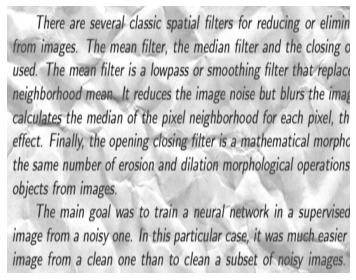

In [31]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF  

selected_images = []

image, label = val_dataset[2]

    
image = TF.to_pil_image(image)  

    
selected_images.append(image)


plt.figure(figsize=(6, 4))

plt.imshow(selected_images[0], cmap='gray')  
   
plt.axis('off')

plt.tight_layout()
plt.savefig('textAEoriginalPic3new.jpg', dpi=150, quality=95)  
plt.show()

In [32]:
from torchvision import datasets,transforms

reconstructed_images1 = []


autoencoder2.eval()



transform2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

with torch.no_grad():
    for image in selected_images:
       
        image_tensor = transform2(image).unsqueeze(dim=0) 
        image_tensor = image_tensor.to('cuda')

        
        reconstructed_image = autoencoder2(image_tensor)
        reconstructed_pil_image = TF.to_pil_image(reconstructed_image.squeeze().cpu())

        
        reconstructed_images1.append(reconstructed_pil_image)

D:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  if __name__ == '__main__':


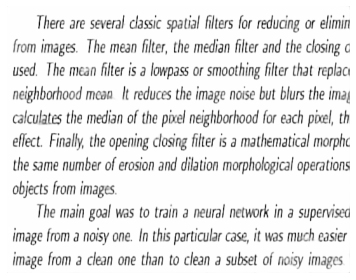

In [33]:

plt.figure(figsize=(6, 4))

plt.imshow(reconstructed_images1[0], cmap='gray') 

plt.axis('off')

plt.tight_layout()
plt.savefig('textAEOptunaPaylu3.jpg', dpi=150, quality=95)  
plt.show()